In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
imagePaths = list(paths.list_images('/gdrive/My Drive/Colab Notebooks/Mask face detector/2nd_trie/dataset'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
 
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
print(data.shape)
print(labels.shape)

print(data[0:5])
print(labels)

(3833, 224, 224, 3)
(3833,)
[[[[ 0.6392157   0.6784314   0.6313726 ]
   [ 0.6392157   0.6784314   0.6313726 ]
   [ 0.7254902   0.7411765   0.7019608 ]
   ...
   [ 0.827451    0.84313726  0.8039216 ]
   [ 0.827451    0.84313726  0.8039216 ]
   [ 0.827451    0.84313726  0.8039216 ]]

  [[ 0.6392157   0.6784314   0.6313726 ]
   [ 0.6392157   0.6784314   0.6313726 ]
   [ 0.7254902   0.7411765   0.7019608 ]
   ...
   [ 0.827451    0.84313726  0.8039216 ]
   [ 0.827451    0.84313726  0.8039216 ]
   [ 0.827451    0.84313726  0.8039216 ]]

  [[ 0.70980394  0.7490196   0.7019608 ]
   [ 0.70980394  0.7490196   0.7019608 ]
   [ 0.8039216   0.81960785  0.78039217]
   ...
   [ 0.8509804   0.8666667   0.827451  ]
   [ 0.8352941   0.8509804   0.8117647 ]
   [ 0.8352941   0.8509804   0.8117647 ]]

  ...

  [[-0.6313726  -0.7647059  -0.827451  ]
   [-0.6313726  -0.7647059  -0.827451  ]
   [-0.78039217 -0.8901961  -0.9607843 ]
   ...
   [ 0.05882359 -0.1607843  -0.3333333 ]
   [ 0.12156868 -0.09803921 -

In [ ]:
# Apply transfer learning and fine tunning

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process (freeze the model)
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Binarize and transform the labels to categorial: 1 mask, 0 no mask
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
#Compile and fit the model

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 157s 2s/step - loss: 0.5416 - accuracy: 0.7498 - val_loss: 0.1686 - val_accuracy: 0.9739
Epoch 2/20
95/95 [==============================] - 152s 2s/step - loss: 0.1674 - accuracy: 0.9589 - val_loss: 0.1010 - val_accuracy: 0.9778
Epoch 3/20
95/95 [==============================] - 152s 2s/step - loss: 0.0958 - accuracy: 0.9759 - val_loss: 0.0788 - val_accuracy: 0.9791
Epoch 4/20
95/95 [==============================] - 152s 2s/step - loss: 0.0672 - accuracy: 0.9843 - val_loss: 0.0670 - val_accuracy: 0.9791
Epoch 5/20
95/95 [==============================] - 152s 2s/step - loss: 0.0586 - accuracy: 0.9845 - val_loss: 0.0649 - val_accuracy: 0.9804
Epoch 6/20
95/95 [==============================] - 151s 2s/step - loss: 0.0531 - accuracy: 0.9872 - val_loss: 0.0564 - val_accuracy: 0.9817
Epoch 7/20
95/95 [==============================] - 153s 2s/step - loss: 0.0499 - accuracy: 0.9859 - val

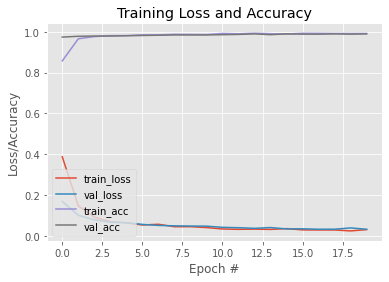

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.save('/gdrive/My Drive/Colab Notebooks/Mask face detector/2nd_trie/mask_recognizer.h5')

DOCUMENTATION:

https://www.mygreatlearning.com/blog/real-time-face-detection/